Visualization & Task‑Aware Segmentation Demo



In [1]:
from google.colab import drive
drive.mount('/content/drive')

!pip install -q segment-anything
!pip install -q transformers
!pip install -q accelerate
!pip install -q opencv-python
!pip install -q matplotlib
!pip install -q tqdm
!pip install -q wandb
!pip install -U datasets
!pip install fsspec==2023.9.2

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P /content/checkpoints/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 100.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 16.7 MB/s eta 

In [1]:
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
import json
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

PROJECT_PATH = '/content/drive/MyDrive/task_aware_sam_lora'
sys.path.append(PROJECT_PATH)
!unzip -q "/content/drive/MyDrive/checkpoints.zip" -d checkpoints/

from config.train_config import get_t4_optimized_config
from src.models.sam_wrapper import SAMWithLoRA
from src.models.hypernetwork import TaskAwareHyperNet
from src.models.lora_adapter import LoRAAdapter
from src.data.dataset import TaskAwareDataset
from src.utils.text_processing import TaskDescriptionProcessor

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

Using device: cuda
GPU: Tesla T4
GPU Memory: 14.7 GB


In [2]:
#construct
#load config
cfg = get_t4_optimized_config()
base_cfg   = get_t4_optimized_config()
model_cfg  = base_cfg.model
system_cfg = base_cfg.system

device = system_cfg.device
#build SAM+LoRA wrapper
from src.models.lora_adapter import LoRAConfig
from src.models.hypernetwork import create_sam_lora_config


lora_cfg = LoRAConfig(
    rank=cfg.model.lora_rank,
    alpha=cfg.model.lora_alpha,
    dropout=cfg.model.lora_dropout,
    target_modules=cfg.model.lora_target_modules,
)

sam_model = SAMWithLoRA(
    sam_checkpoint=cfg.model.sam_checkpoint,
    model_type=cfg.model.sam_model_type,
    lora_config=lora_cfg,
    device=device
)

#build hypernetwork
lora_config_dict = create_sam_lora_config(sam_model.sam.mask_decoder)
hypernetwork = TaskAwareHyperNet(
    lora_config=lora_config_dict,
    lora_rank=model_cfg.lora_rank,
    text_encoder_model=model_cfg.text_encoder_model,
    hidden_dim=model_cfg.hypernetwork_hidden_dim,
    num_layers=model_cfg.hypernetwork_num_layers,
    num_heads=model_cfg.hypernetwork_num_heads,
    dropout=model_cfg.hypernetwork_dropout
).to(device)

text_processor = TaskDescriptionProcessor()


Frozen SAM encoders
Added LoRA to: output_hypernetworks_mlps.0.layers.0 (as output_hypernetworks_mlps_0_layers_0)
Added LoRA to: output_hypernetworks_mlps.0.layers.1 (as output_hypernetworks_mlps_0_layers_1)
Added LoRA to: output_hypernetworks_mlps.0.layers.2 (as output_hypernetworks_mlps_0_layers_2)
Added LoRA to: output_hypernetworks_mlps.1.layers.0 (as output_hypernetworks_mlps_1_layers_0)
Added LoRA to: output_hypernetworks_mlps.1.layers.1 (as output_hypernetworks_mlps_1_layers_1)
Added LoRA to: output_hypernetworks_mlps.1.layers.2 (as output_hypernetworks_mlps_1_layers_2)
Added LoRA to: output_hypernetworks_mlps.2.layers.0 (as output_hypernetworks_mlps_2_layers_0)
Added LoRA to: output_hypernetworks_mlps.2.layers.1 (as output_hypernetworks_mlps_2_layers_1)
Added LoRA to: output_hypernetworks_mlps.2.layers.2 (as output_hypernetworks_mlps_2_layers_2)
Added LoRA to: output_hypernetworks_mlps.3.layers.0 (as output_hypernetworks_mlps_3_layers_0)
Added LoRA to: output_hypernetworks_mlps

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

TaskAwareHyperNet initialized with 26128 LoRA parameters
  output_hypernetworks_mlps.0.layers.0: 256x256, LoRA A: 1024, LoRA B: 1024
  output_hypernetworks_mlps.0.layers.1: 256x256, LoRA A: 1024, LoRA B: 1024
  output_hypernetworks_mlps.0.layers.2: 256x32, LoRA A: 1024, LoRA B: 128
  output_hypernetworks_mlps.1.layers.0: 256x256, LoRA A: 1024, LoRA B: 1024
  output_hypernetworks_mlps.1.layers.1: 256x256, LoRA A: 1024, LoRA B: 1024
  output_hypernetworks_mlps.1.layers.2: 256x32, LoRA A: 1024, LoRA B: 128
  output_hypernetworks_mlps.2.layers.0: 256x256, LoRA A: 1024, LoRA B: 1024
  output_hypernetworks_mlps.2.layers.1: 256x256, LoRA A: 1024, LoRA B: 1024
  output_hypernetworks_mlps.2.layers.2: 256x32, LoRA A: 1024, LoRA B: 128
  output_hypernetworks_mlps.3.layers.0: 256x256, LoRA A: 1024, LoRA B: 1024
  output_hypernetworks_mlps.3.layers.1: 256x256, LoRA A: 1024, LoRA B: 1024
  output_hypernetworks_mlps.3.layers.2: 256x32, LoRA A: 1024, LoRA B: 128
  iou_prediction_head.layers.0: 256x256

In [3]:
#oad the raw checkpoint
sam_ckpt = "/content/drive/MyDrive/sam_vit_h_4b8939.pth"

raw_ckpt = torch.load(sam_ckpt, map_location=device)
base_keys = set(sam_model.sam.state_dict().keys())
#filter
backbone_dict = {k: v for k, v in raw_ckpt.items() if k in base_keys}
sam_model.sam.load_state_dict(backbone_dict, strict=False)


_IncompatibleKeys(missing_keys=['mask_decoder.output_hypernetworks_mlps.0.layers.0.original_layer.weight', 'mask_decoder.output_hypernetworks_mlps.0.layers.0.original_layer.bias', 'mask_decoder.output_hypernetworks_mlps.0.layers.0.lora.lora_A', 'mask_decoder.output_hypernetworks_mlps.0.layers.0.lora.lora_B', 'mask_decoder.output_hypernetworks_mlps.0.layers.1.original_layer.weight', 'mask_decoder.output_hypernetworks_mlps.0.layers.1.original_layer.bias', 'mask_decoder.output_hypernetworks_mlps.0.layers.1.lora.lora_A', 'mask_decoder.output_hypernetworks_mlps.0.layers.1.lora.lora_B', 'mask_decoder.output_hypernetworks_mlps.0.layers.2.original_layer.weight', 'mask_decoder.output_hypernetworks_mlps.0.layers.2.original_layer.bias', 'mask_decoder.output_hypernetworks_mlps.0.layers.2.lora.lora_A', 'mask_decoder.output_hypernetworks_mlps.0.layers.2.lora.lora_B', 'mask_decoder.output_hypernetworks_mlps.1.layers.0.original_layer.weight', 'mask_decoder.output_hypernetworks_mlps.1.layers.0.original

In [4]:
#SAM BACKBONE + LoRA ckpnts

#load SAM backbone
sam_ckpt = "/content/drive/MyDrive/sam_vit_h_4b8939.pth"
print("Loading SAM backbone from", sam_ckpt)
raw_ckpt     = torch.load(sam_ckpt, map_location=device)
base_state   = sam_model.sam.state_dict()
filtered_ckpt = {
    k: v for k, v in raw_ckpt.items() if k in base_state
}

sam_model.sam.load_state_dict(filtered_ckpt, strict=False)

#load last LoRA checkpoint
ckpt_dir = "/content/checkpoints/mnt/data/checkpoints"
epoch    = cfg.training.num_epochs - 1
ckpt_path= f"{ckpt_dir}/checkpoint_epoch_{epoch}.pth"
print("Loading LoRA checkpoint from", ckpt_path)
ckpt = torch.load(ckpt_path, map_location=device)
hypernetwork.load_state_dict(ckpt['hypernetwork_state_dict'])
sam_model.load_state_dict(ckpt['sam_state_dict'])
print("Models loaded. Ready for inference!")


Loading SAM backbone from /content/drive/MyDrive/sam_vit_h_4b8939.pth
Loading LoRA checkpoint from /content/checkpoints/mnt/data/checkpoints/checkpoint_epoch_1.pth
Models loaded. Ready for inference!


In [5]:
dataset=TaskAwareDataset(
    data_dir="/content/drive/MyDrive/coco",
    split="train",
    max_samples=10,
    transform=None,
    task_templates= cfg.data.task_templates,
    mode="instance"
)


loading annotations into memory...
Done (t=1.52s)
creating index...
index created!


[DEBUG] image_embeddings shape: torch.Size([1, 256, 64, 64])
[DEBUG] point_coords shape: torch.Size([1, 1, 2])
[DEBUG] point_labels shape: torch.Size([1, 1])
[DEBUG] sparse_embeddings shape: torch.Size([1, 2, 256])
[DEBUG] dense_embeddings shape: torch.Size([1, 256, 64, 64])
[DEBUG] image_pe shape: torch.Size([1, 256, 64, 64])
[DEBUG] dense_embeddings final shape: torch.Size([1, 256, 64, 64])
[DEBUG] image_embeddings shape: torch.Size([1, 256, 64, 64])
[DEBUG] point_coords shape: torch.Size([1, 1, 2])
[DEBUG] point_labels shape: torch.Size([1, 1])
[DEBUG] sparse_embeddings shape: torch.Size([1, 2, 256])
[DEBUG] dense_embeddings shape: torch.Size([1, 256, 64, 64])
[DEBUG] image_pe shape: torch.Size([1, 256, 64, 64])
[DEBUG] dense_embeddings final shape: torch.Size([1, 256, 64, 64])


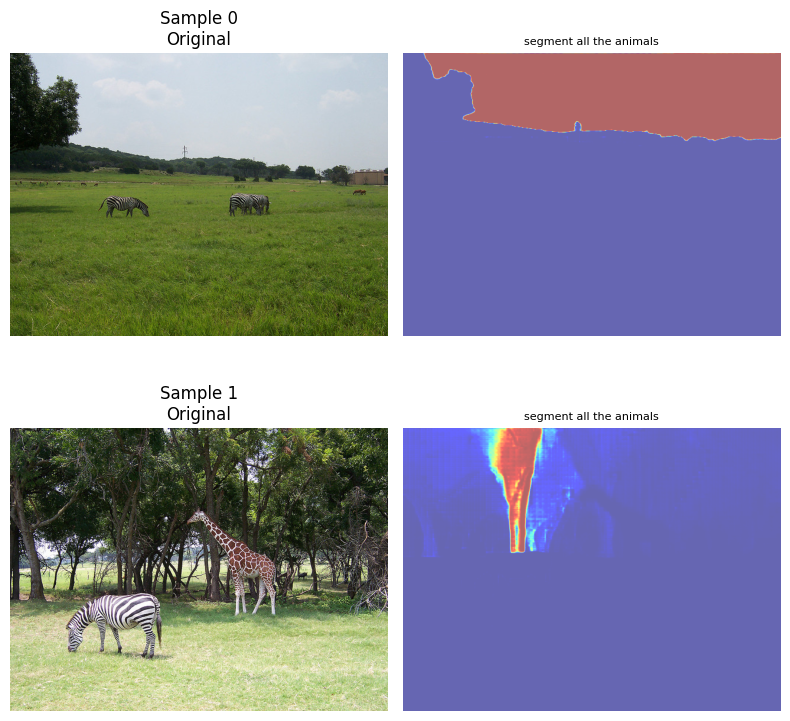

In [30]:
#visual helpers
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import numpy as np

def demo_batch_segmentation(dataset, tasks, num_samples=3, device='cuda'):
    rows = min(num_samples, len(dataset))
    cols = 1 + len(tasks)
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
    if rows == 1:
        axes = axes[None, :]  #ensureing 2D indexing

    for i in range(rows):
        sample = dataset[i]
        img = sample['image']
        if isinstance(img, torch.Tensor):
            img_np = img.detach().cpu().numpy().transpose(1,2,0)
        else:
            img_np = img

        h, w = img_np.shape[:2]
        #show original
        axes[i,0].imshow(img_np)
        axes[i,0].set_title(f"Sample {i}\nOriginal")
        axes[i,0].axis('off')

        for j, task in enumerate(tasks, start=1):
            with torch.no_grad():
                #generate & apply LoRA
                lora = hypernetwork([task])
                sam_model.apply_lora(lora)

                #get embeddings: accepts HWC numpy
                emb = sam_model.get_image_embeddings(img_np)
                if isinstance(emb, np.ndarray):
                    emb = torch.from_numpy(emb)
                #now emb is tensor
                if emb.ndim == 3:
                    emb = emb.unsqueeze(0)
                emb = emb.to(device)

                #pick a center point
                pts  = torch.tensor([[[w//2, h//2]]], dtype=torch.float, device=device)
                lbls = torch.tensor([[1]], dtype=torch.long,  device=device)

                #forward
                pred, _ = sam_model(
                    image_embeddings=emb,
                    point_coords=pts,
                    point_labels=lbls,
                    multimask_output=False
                )
                #upsample & sigmoid
                pred = F.interpolate(pred, size=(h, w), mode='bilinear', align_corners=False)
                mask = torch.sigmoid(pred)[0,0].cpu().numpy()

            #plot mask
            axes[i,j].imshow(mask, cmap='jet', alpha=0.6)
            axes[i,j].set_title(task, fontsize=8)
            axes[i,j].axis('off')

    plt.tight_layout()
    plt.show()

tasks = [
    "segment all the animals"
]
demo_batch_segmentation(dataset, tasks, num_samples=2, device=device)


In [20]:
#generate per‑annotation predictions
import os, json
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from pycocotools.coco import COCO
from pycocotools import mask as maskUtils

def generate_instance_preds_by_point(inst_ann, img_dir, out_json):
    coco = COCO(inst_ann)
    anns = coco.loadAnns(coco.getAnnIds())
    results = []

    for ann in anns:
        img_info = coco.loadImgs(ann["image_id"])[0]
        img_path = os.path.join(img_dir, img_info["file_name"])
        if not os.path.isfile(img_path):
            continue

        #load nd preprocess image
        img = Image.open(img_path).convert("RGB")
        img_np = np.array(img)
        h, w = img_np.shape[:2]

        #generate LoRA weights for a generic prompt
        lora = hypernetwork(["segment objects"])
        sam_model.apply_lora(lora)

        #get image embeddings
        emb = sam_model.get_image_embeddings(img_np).squeeze(0).unsqueeze(0).to(device)

        #compute center point of bbox
        x, y, bw, bh = ann["bbox"]
        cx = x + bw/2
        cy = y + bh/2
        pts = torch.tensor([[[cx, cy]]], dtype=torch.float, device=device)
        lbls = torch.tensor([[1]], dtype=torch.long, device=device)

        #predict single mask
        with torch.no_grad():
            pred, _ = sam_model(
                image_embeddings=emb,
                point_coords=pts,
                point_labels=lbls,
                multimask_output=False
            )
            #upsample nd sigmoid
            pred = F.interpolate(pred, size=(h, w), mode="bilinear", align_corners=False)
            mask_np = torch.sigmoid(pred)[0,0].cpu().numpy()

        #encode to RLE
        bin_mask = (mask_np > 0.5).astype(np.uint8)
        rle = maskUtils.encode(np.asfortranarray(bin_mask))
        rle["counts"] = rle["counts"].decode("ascii")

        #dummy score
        x1, y1, x2, y2 = int(x), int(y), int(x + bw), int(y + bh)
        score = float(mask_np[y1:y2, x1:x2].mean())

        results.append({
            "image_id":    ann["image_id"],
            "category_id": ann["category_id"],
            "segmentation": rle,
            "score":       score
        })

    print(f"✅ Generated {len(results)} predictions.")
    with open(out_json, "w") as f:
        json.dump(results, f)

inst_ann    = "/content/drive/MyDrive/coco/annotations/instances_val2017.json"
img_dir     = "/content/drive/MyDrive/coco/images/val2017"
predictions = "predictions.json"

generate_instance_preds_by_point(inst_ann, img_dir, predictions)


Streaming output truncated to the last 5000 lines.
[DEBUG] dense_embeddings final shape: torch.Size([1, 256, 64, 64])
[DEBUG] image_embeddings shape: torch.Size([1, 256, 64, 64])
[DEBUG] point_coords shape: torch.Size([1, 1, 2])
[DEBUG] point_labels shape: torch.Size([1, 1])
[DEBUG] sparse_embeddings shape: torch.Size([1, 2, 256])
[DEBUG] dense_embeddings shape: torch.Size([1, 256, 64, 64])
[DEBUG] image_pe shape: torch.Size([1, 256, 64, 64])
[DEBUG] dense_embeddings final shape: torch.Size([1, 256, 64, 64])
[DEBUG] image_embeddings shape: torch.Size([1, 256, 64, 64])
[DEBUG] point_coords shape: torch.Size([1, 1, 2])
[DEBUG] point_labels shape: torch.Size([1, 1])
[DEBUG] sparse_embeddings shape: torch.Size([1, 2, 256])
[DEBUG] dense_embeddings shape: torch.Size([1, 256, 64, 64])
[DEBUG] image_pe shape: torch.Size([1, 256, 64, 64])
[DEBUG] dense_embeddings final shape: torch.Size([1, 256, 64, 64])
[DEBUG] image_embeddings shape: torch.Size([1, 256, 64, 64])
[DEBUG] point_coords shape: t

In [21]:
#eval with COCOeval
from pycocotools.cocoeval import COCOeval
from pycocotools.coco import COCO

coco_gt   = COCO(inst_ann)
coco_pred = coco_gt.loadRes(predictions)

eval = COCOeval(coco_gt, coco_pred, iouType="segm")
eval.params.imgIds = coco_gt.getImgIds()
eval.evaluate()
eval.accumulate()
eval.summarize()


loading annotations into memory...
Done (t=0.46s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.04s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=8.75s).
Accumulating evaluation results...
DONE (t=1.65s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets